In [1]:
import os
import numpy as np
from astropy.table import Table
from astropy.io import fits
import pylab as pl
from glob import glob
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask

In [2]:
flavour = 'bright'
# flavour = 'dark'

if flavour == 'bright':
    path = '/global/cfs/cdirs/desi/target/catalogs/dr9/1.0.0/targets/main/resolve/bright'
elif flavour == 'dark':
    path = '/global/cfs/cdirs/desi/target/catalogs/dr9/1.0.0/targets/main/resolve/dark'

In [3]:
files = np.sort(glob(f'{path}/*hp*'))
print(files[0])

/global/cfs/cdirs/desi/target/catalogs/dr9/1.0.0/targets/main/resolve/bright/targets-bright-hp-0.fits


In [4]:
len(files)

466

In [5]:
file = files[0]
hdu = fits.open(file)

In [6]:
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [7]:
hdu[1].data.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'RA',
 'RA_IVAR',
 'DEC',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'REF_EPOCH',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'MASKBITS',
 'LC_FLUX_W1',
 'LC_FLUX_W2',
 'LC_FLUX_IVAR_W1',
 'LC

In [13]:
np.unique(hdu[1].data['TARGETID'])

array([39627785479654746, 39627785479655252, 39627785479655281, ...,
       39636714305624327, 39636714305624335, 39636714305624406])

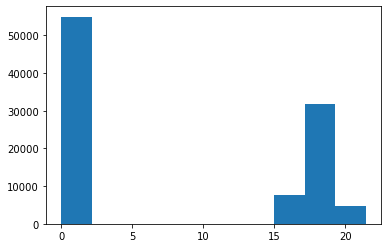

In [9]:
_ = pl.hist(hdu[1].data['GAIA_PHOT_G_MEAN_MAG'])

In [10]:
# Reading the R value: Half-light radius of galaxy model
# Reading the E1 value: Ellipticity component 1 of galaxy model
# Reading the E2 value: Ellipticity component 2 of galaxy model
# https://www.legacysurvey.org/dr9/catalogs/#ellipticities
R = []
E1 = []
E2 = []
RA = []
DEC = []
GMAG = []
TARGETID = []

for file in files:
    hdu = fits.open(file)
    
    if flavour == 'bright':
        is_target = (hdu[1].data['BGS_TARGET'] & bgs_mask['BGS_BRIGHT'])!=0
    else:
        is_target = (hdu[1].data['DESI_TARGET'] & desi_mask['LRG'])!=0
    
    R.append( hdu[1].data['SHAPE_R'][is_target] )

    e1 = hdu[1].data['SHAPE_E1'][is_target]
    E1.append( e1 )
    
    e2 = hdu[1].data['SHAPE_E2'][is_target]
    E2.append( e2 )
    
    RA.append( hdu[1].data['RA'][is_target] )
    
    DEC.append( hdu[1].data['DEC'][is_target] )
    
    GMAG.append( hdu[1].data['GAIA_PHOT_G_MEAN_MAG'][is_target] )
    
    TARGETID.append( hdu[1].data['TARGETID'][is_target] )

In [11]:
R_all = np.concatenate(R).ravel()
GMAG_all = np.concatenate(GMAG).ravel()
RA_all = np.concatenate(RA).ravel()
DEC_all = np.concatenate(DEC).ravel()
E1_all = np.concatenate(E1).ravel()
E2_all = np.concatenate(E2).ravel()
E_all =  np.sqrt(E1_all**2 + E2_all**2)
BA_all = (1 - np.abs(E_all))/(1 + np.abs(E_all))
PHI_all = 0.5*np.arctan2(E2_all,E1_all)
TARGETID_all = np.concatenate(TARGETID, dtype=int).ravel()

In [12]:
# len(R_all)

In [13]:
# _ = pl.hist(R_all)

In [14]:
# _ = pl.hist(E1_all)

In [15]:
# _ = pl.hist(E2_all)

In [16]:
# _ = pl.hist(E_all)

In [17]:
# _ = pl.hist(BA_all)

In [18]:
# _ = pl.hist(PHI_all)

In [19]:
# max(E1_all), min(E1_all)

## Removing E1==0 and E2==0

In [20]:
# Remove elements with E1==0
E1_all_nonzeros = E1_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
E2_all_nonzeros = E2_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
GMAG_all_nonzeros = GMAG_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
R_all_nonzeros = R_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
RA_all_nonzeros = RA_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
DEC_all_nonzeros = DEC_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]
TARGETID_all_nonzeros = TARGETID_all[(E1_all != 0) & (E2_all != 0) & (GMAG_all != 0)]

E_all_nonzeros = np.sqrt(E1_all_nonzeros**2 + E2_all_nonzeros**2)
BA_all_nonzeros = ((1 - np.abs(E_all_nonzeros))/(1 + np.abs(E_all_nonzeros)))
PHI_all_nonzeros = (0.5*np.arctan2(E2_all_nonzeros, E1_all_nonzeros))

In [21]:
print(f'Total objects: {len(E1_all)}\nTotal non zero E1: {len(E1_all_nonzeros)}\nTotal selected: {len(E1_all_nonzeros)/len(E1_all)*100:.1f}%')

Total objects: 16938694
Total non zero E1: 1716755
Total selected: 10.1%


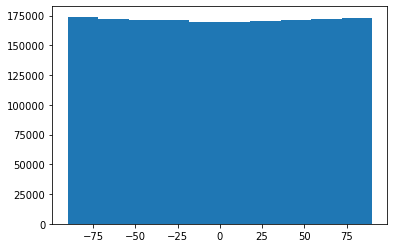

In [22]:
_ = pl.hist(PHI_all_nonzeros*180/np.pi)

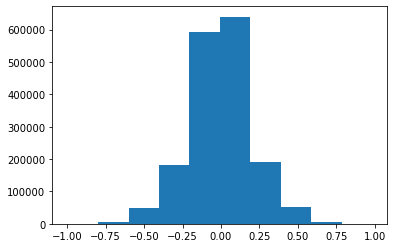

In [23]:
_ = pl.hist(E1_all_nonzeros)

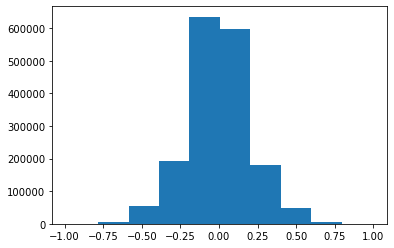

In [24]:
_ = pl.hist(E2_all_nonzeros)

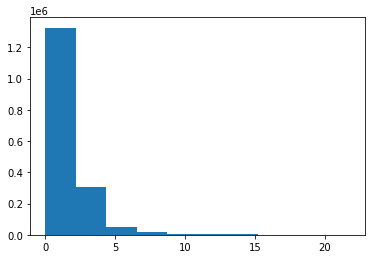

In [25]:
_ = pl.hist(R_all_nonzeros)

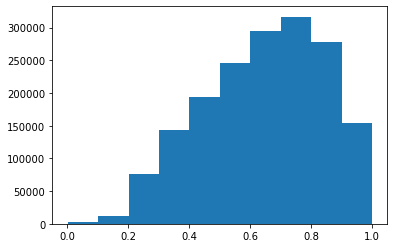

In [26]:
_ = pl.hist(BA_all_nonzeros)

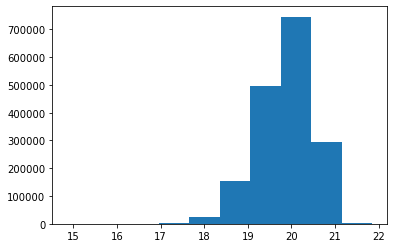

In [27]:
_ = pl.hist(GMAG_all_nonzeros)

In [28]:
sum(GMAG_all_nonzeros != 0)

1716755

In [29]:
import seaborn as sns
import pandas as pd

In [30]:
idx = np.arange(0,len(RA_all_nonzeros))
df = pd.DataFrame(np.c_[idx, RA_all_nonzeros, DEC_all_nonzeros, TARGETID_all_nonzeros, E1_all_nonzeros, E2_all_nonzeros, E_all_nonzeros,
                        R_all_nonzeros, BA_all_nonzeros, PHI_all_nonzeros, GMAG_all_nonzeros],
                  columns=['ID','RA','DEC','TARGETID','E1','E2','E','R','BA','PHI','GMAG'])
if flavour == 'bright':
    df.to_csv('./data/DR9_BGSBRIGHT_data.csv', index=False)
else:
    df.to_csv('./data/DR9_LRG_data.csv', index=False)

In [31]:
if flavour == 'bright':
    np.savetxt('./data/DR9_BGSBRIGTH_radec.txt', df[['ID','RA','DEC']].values, fmt='%d %f %f', header='# id ra dec')
else:
    np.savetxt('./data/DR9_LRG_radec.txt', df[['ID','RA','DEC']].values, fmt='%d %f %f', header='# id ra dec')

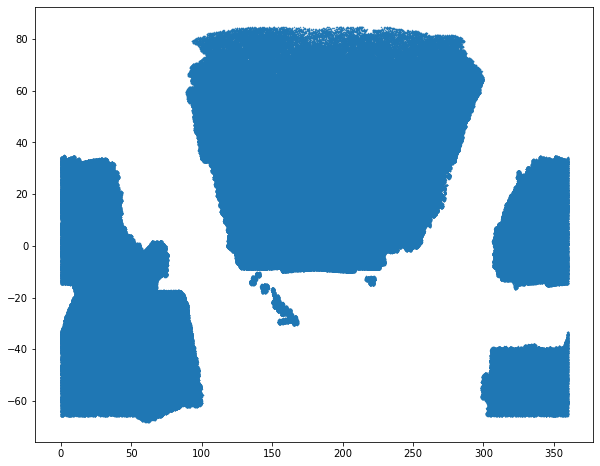

In [32]:
fig = pl.figure(figsize=(10,8))
pl.scatter(df['RA'], df['DEC'], s=0.2)
pl.show()

In [33]:
# fig = pl.figure(figsize=(10,8))
# pl.scatter(df['RA'], df['DEC'], s=0.2, c=GMAG_all_nonzeros)
# pl.show()

In [34]:
# _ = pl.hist(GMAG_all_nonzeros)